Loading the data from Google Drive:

In [1]:
from google.colab import drive

drive.mount._DEBUG = True
drive.mount('/content/gdrive', force_remount=True)
root_path = 'gdrive/My Drive/Simplon/'

unset HISTFILE; export PS1="root@d2170d0d8bb3-97e3b6ba7565445a840509a28979cc7e: "
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
/content# root@d2170d0d8bb3-97e3b6ba7565445a840509a28979cc7e: umount -f /content/gdrive || umount /content/gdrive; pkill -9 -x drive
umount: /content/gdrive: no mount point specified.
umount: /content/gdrive: no mount point specified.
root@d2170d0d8bb3-97e3b6ba7565445a840509a28979cc7e: pkill -9 -f /opt/google/drive/directoryprefetcher_binary
root@d2170d0d8bb3-97e3b6ba7565445a840509a28979cc7e: ( while `sleep 0.5`; do if [[ -d "/content/gdrive" && "$(ls -A /content/gdrive)" != "" ]]; then echo "google.colab.drive MOUNTED"; break; fi; done ) &
[1] 90
root@d2170d0d8bb3-97e3b6ba7565445a840509a28979cc7e: cat /tmp/tmprawn_4rw/drive.fifo | head -1 | ( /opt/google/drive/drive --features=fuse_max_background:1000,max_read_qps:1000,max_write_qps:1000,max_operation_batch_size:15,max_parallel_push_task_instan

In [2]:
file = ''.join(root_path+'cartoonset10k.zip')
file

'gdrive/My Drive/Simplon/cartoonset10k.zip'

In [3]:
!mkdir datas
import zipfile
with zipfile.ZipFile(file,"r") as zip_ref:
    zip_ref.extractall("datas")

In [56]:
path = '/content/datas/cartoonset10k'
import os
from skimage.io import imread
for file in os.listdir(path):
    if (file[-3:] in {'csv'}):
        #print(os.path.join(path, file))
        os.remove(os.path.join(path, file))

In [57]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile


In [58]:
dataset = keras.preprocessing.image_dataset_from_directory(
    "/content/datas/", label_mode=None, image_size=(64, 64), batch_size=32
)


Found 10000 files belonging to 1 classes.


In [59]:
dataset = dataset.map(lambda x: x / 255.0)


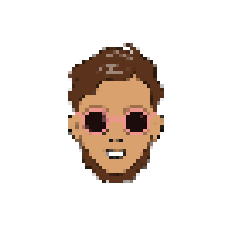

In [60]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break


Creating the Discriminator, Generator, and  GAN:

In [61]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()


Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 128)         262272    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)            

In [62]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()


Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 32, 32, 256)       524544    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 64, 64, 512)       20

In [63]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


GANMonitor saves pictures every epoch:

In [64]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("/content/gdrive/MyDrive/Simplon/avatars/generated_img_%03d_%d.png" % (epoch, i))


In [65]:

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)




Running the GAN, 'fit' was executed multiple times:

In [87]:
epochs = 15  # In practice, use ~100 epochs

history = gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)


Epoch 1/15
313/313 [==============================] - 124s 394ms/step - d_loss: 0.2867 - g_loss: 2.0364
Epoch 2/15
313/313 [==============================] - 125s 397ms/step - d_loss: 0.2826 - g_loss: 2.0707
Epoch 3/15
313/313 [==============================] - 126s 398ms/step - d_loss: 0.2874 - g_loss: 2.0597
Epoch 4/15
313/313 [==============================] - 126s 398ms/step - d_loss: 0.2515 - g_loss: 2.2281
Epoch 5/15
313/313 [==============================] - 126s 399ms/step - d_loss: 0.2779 - g_loss: 2.1571
Epoch 6/15
313/313 [==============================] - 125s 397ms/step - d_loss: 0.2745 - g_loss: 2.1549
Epoch 7/15
313/313 [==============================] - 125s 397ms/step - d_loss: 0.2545 - g_loss: 2.2232
Epoch 8/15
313/313 [==============================] - 125s 397ms/step - d_loss: 0.2537 - g_loss: 2.2480
Epoch 9/15
313/313 [==============================] - 125s 397ms/step - d_loss: 0.2443 - g_loss: 2.2879
Epoch 10/15
313/313 [==============================] - 125s 397m

Saving the weights:

In [88]:
gan.save_weights("/content/gdrive/MyDrive/Simplon/avatars_model/saved.h5")

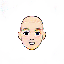

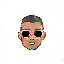

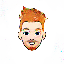

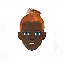

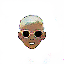

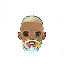

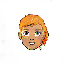

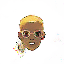

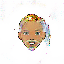

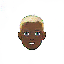

In [89]:
import IPython.display as display
from PIL import Image

for i in range(10):
  image_path = '/content/gdrive/MyDrive/Simplon/avatars/generated_img_014_'+str(i)+'.png'
  display.display(Image.open(image_path))

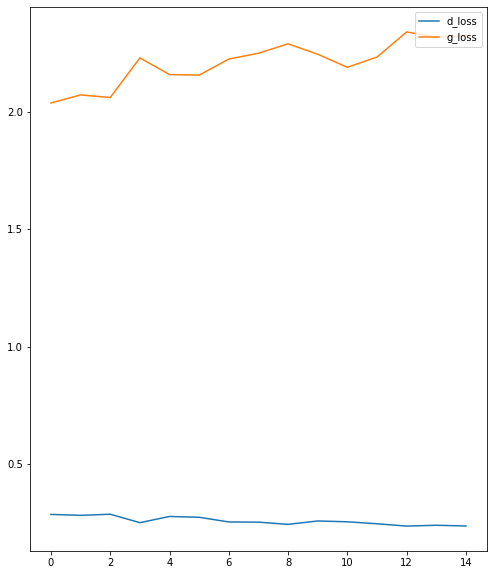

In [90]:
import matplotlib.pyplot as plt

#acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']

loss = history.history['d_loss']
val_loss = history.history['g_loss']

epochs_range = range(epochs)

plt.figure(figsize=(18, 10))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='d_loss')
plt.plot(epochs_range, val_loss, label='g_loss')
plt.legend(loc='upper right')
plt.title('')
plt.show()

Reloading the GAN weights from file and testing it:

In [92]:
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)
gan.built=True
gan.load_weights("/content/gdrive/MyDrive/Simplon/avatars_model/saved.h5")

In [93]:
history = gan.fit(
    dataset, epochs=1, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

313/313 [==============================] - 127s 398ms/step - d_loss: 0.2477 - g_loss: 2.2537


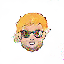

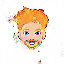

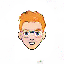

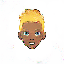

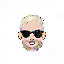

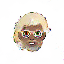

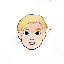

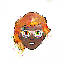

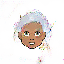

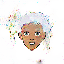

In [97]:
for i in range(10):
  image_path = '/content/gdrive/MyDrive/Simplon/avatars/generated_img_000_'+str(i)+'.png'
  display.display(Image.open(image_path))

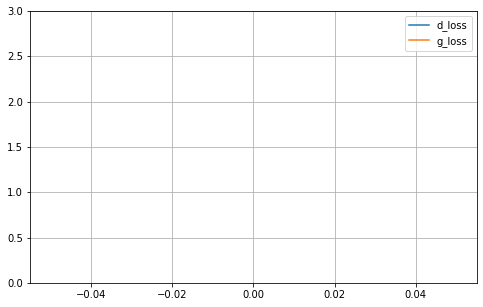

In [96]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,3)
plt.show()